# **PROYECTO HUMOR** Modelo Mutliclase con LSTM

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [70]:
# Importación de librerias de python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

# Scikit-learn: División de datos y otras utilidades para machine learning
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# TensorFlow / Keras: Construcción y entrenamiento de redes neuronales
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model

# Conexión con drive para obtener el dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Carga de los datos**

Primero, se extraen los 10000 datos chistosos y los otros 10000 datos no chistosos. En total son 20000 registros.

In [71]:
url_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/humor_dataset.csv"
url_non_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/datosNochistosos.csv"

df_graceful = pd.read_csv(url_graceful_dataset)
df_non_graceful = pd.read_csv(url_non_graceful_dataset)

dataset = pd.concat([df_graceful, df_non_graceful])
dataset['promedio_gracioso'] = dataset[['nivel_gracia_p1', 'nivel_gracia_p2', 'nivel_gracia_p3']].mean(axis=1).fillna(0).astype(int)
dataset['Es_gracioso'] = dataset['Es_gracioso'].fillna(0)

# Se muestra 5 ejemplos aleatorios del dataset donde la columna "promedio_gracioso" indica el nivel de chiste
print(dataset.shape)
dataset.sample(n=3)

(20000, 21)


,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,...,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target,promedio_gracioso
6914,6915,Un hombre que va de compras con su pareja es c...,Internet/Twitter,1.0,1.0,1.0,1.0,4.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
9597,9598,zi3qtm_Nací con privilegios ilimitados hagan s...,Imágenes/Internet,1.0,1.0,0.0,1.0,3.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4956,4957,Las fotos familiares siempre tienen al menos u...,LLMs,1.0,1.0,0.0,1.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## **2. Preprocesamiento de los datos**

Segundo, para el preprocesamiento usamos varios pasos. Primero se reemplazan URLs, menciones de usuarios, hashtags y emojis por tokens genéricos (<URL'>, <USUARIO'>, <HASH_TAG'>, <EMOJI'>), lo que reduce la dimensionalidad del texto sin perder contexto. Además, se convierte todo a minúsculas para uniformidad, se eliminan signos de puntuación y nombres de archivos irrelevantes.

In [72]:
"""
Función para limpiar un texto (chiste) que entra por parámetro
"""
def preprocess_text(text):
    # Transformación de las URLs a su token <URL>
    text = re.sub(r'http\S+', '<URL>', text)

    # Transformación de las menciones de usaurio a su token <USUARIO>
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Dejar en miniscula el texto
    text = text.lower()

    # Eliminar emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transformación de los hashtags a su token <HASH_TAG>
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)

    # Transformación de las imagenes a su token <IMAGE>
    result = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>", text)

    return text

dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset[['text', 'Es_gracioso', 'promedio_gracioso']]
dataset.sample(n=3)

,text,Es_gracioso,promedio_gracioso
4362,ven cuando quieras pero asegúrate de llamar an...,1.0,2
9360,bien ahí q tengo unas amigas de fierro que est...,0.0,0
4188,cuando te dicen vamos juntos pero tú terminas ...,1.0,2


## **3. Partición de los datos**

Tercero, se realiza una revisión de la distribuión de los datos para verificar un correcto balanceo de las clases.

In [73]:
"""
Función para graficar la distribución de los datos
"""
def graficar_distribucion(class_counts):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d", hue=class_counts.index)

    # Añadir los números sobre las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title("Distribución de Clases en el Conjunto de Datos")
    plt.xlabel("Clase")
    plt.ylabel("Número de Muestras")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)
    plt.show()

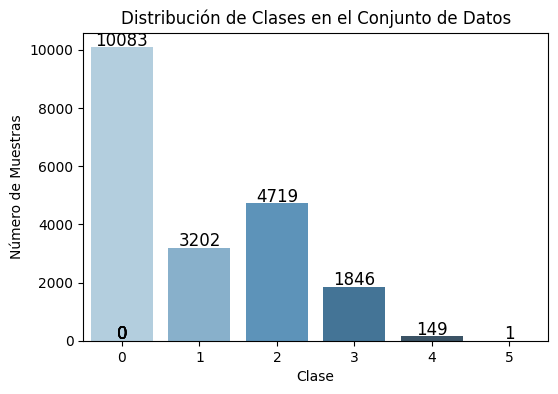

In [74]:
# Distribución inicial de los datos de cada clase
graficar_distribucion(dataset['promedio_gracioso'].value_counts())

Se puede observar que hay un gran desbalanceo en las clases, para evitar este desbalanceo, se decidió limitar todas las clases a 2000 datos. Por otro lado, al tener la clase 4 y 5 pocos datos también se decidió por unificarlo con la clase 3, por ende, la clase 3, 4 y 5 corresponden a la misma clase.

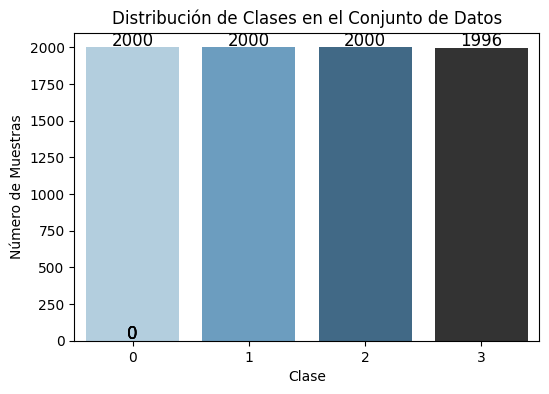

In [75]:
# Variable para definir el número máximo de datos en cada clase
max_samples_per_class = 2000

# Combinar las clases 4 y 5 en la clase 3
dataset['promedio_gracioso'] = dataset['promedio_gracioso'].replace({5: 4})
dataset['promedio_gracioso'] = dataset['promedio_gracioso'].replace({4: 3})

# Crear una lista para almacenar las muestras balanceadas
balanced_data = []

# Iterar sobre cada clase única en la columna 'promedio_gracioso'
for clase, datos_clase in dataset.groupby('promedio_gracioso'):
    datos_balanceados = resample(
        datos_clase,
        replace=False,
        n_samples=min(max_samples_per_class, len(datos_clase)),
        random_state=2024
    )
    # Agregar los datos balanceados a la lista
    balanced_data.append(datos_balanceados)

# Combinar todas las muestras balanceadas en el DataFrame original
dataset = pd.concat(balanced_data)

# Distribución final de los datos de cada clase
graficar_distribucion(dataset['promedio_gracioso'].value_counts())

Una vez verificado el correcto balanceo de las clase, se hace la partición de los datos dejando un 70% de los datos para entrenamiento, un 15% de los datos para validación y un 15% de los datos para prueba.

In [76]:
# Divide el dataset original en un cojunto entrenamiento y un conjunto auxliar
X_train, X_aux, y_train, y_aux = train_test_split(
    dataset['text'],
    dataset['promedio_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=dataset['promedio_gracioso']
)

# Divide el conjunto auxiliar en un cojunto de prueba y un cojunto de validación
X_val, X_test, y_val, y_test = train_test_split(
    X_aux,
    y_aux,
    random_state=2024,
    test_size=0.5,
    stratify=y_aux
)

Una vez que los datos han sido particionados en conjuntos de entrenamiento, validación y prueba, se procede a realizar la tokenización del texto. Durante esta etapa, cada chiste se convierte en una secuencia de índices numéricos, donde cada número representa una palabra o token específico del vocabulario construido a partir del conjunto de entrenamiento.

Para garantizar que todas las secuencias tengan la misma longitud y puedan ser procesadas por el modelo LSTM, se aplica un paso adicional llamado padding, que rellena las secuencias más cortas con ceros hasta alcanzar una longitud fija (determinada por la longitud máxima en los datos de entrenamiento). Esto asegura que el modelo pueda procesar los datos de manera uniforme y eficiente.

In [77]:
"""
Función para generar el padding para cada conjunto de datos
"""
def tokenize_texts(tokenizer, texts, maxlen):
    # Convertir textos a secuencias de índices
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding para asegurar longitud uniforme
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    return padded_sequences

# Crear y entrenar el tokenizador en el conjunto de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Tamaño del vocabulario:", vocab_size)

# Define una longitud máxima, basada en las secuencias de entrenamiento
MAX_LEN = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train))

# Tokenizar y aplicar padding
X_train_seq = tokenize_texts(tokenizer, X_train, maxlen=MAX_LEN)
X_val_seq = tokenize_texts(tokenizer, X_val, maxlen=MAX_LEN)
X_test_seq = tokenize_texts(tokenizer, X_test, maxlen=MAX_LEN)

Tamaño del vocabulario: 13714


## **4. Construcción y entrenamiento del modelo**

Cuarto, se convierte las etiquetas de las clases (que están en formato numérico) a formato categórico (también conocido como one-hot encoding) para que puedan ser utilizadas en el modelo de clasificación.

In [78]:
# Convierte las etiquetas a formato categórico
num_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Leugo, se realiza la definición del modelo secuencial en Keras compuesto por tres capas principales:

* **Capa de entrada (Input):** Define la forma de las entradas, que en este caso son secuencias de 20 enteros (representando palabras o tokens).

* **Capa de embedding (Embedding):** Convierte las secuencias de enteros (índices de palabras) en vectores de 50 dimensiones, donde cada palabra se representa por un vector denso de 50 características.

* **Capa LSTM:** Una capa recurrente LSTM (Long Short-Term Memory) con 100 unidades, que procesa las secuencias de entrada y captura las dependencias a largo plazo en los datos.

* **Capa Profunda:** Una capa completamente conectada con 64 unidades y activación ReLU. Esta capa introduce no linealidades y permite al modelo aprender representaciones más complejas.

* **Capa de salida (Dense):** Capa final con tantas unidades como clases de salida (num_classes), utilizando la activación softmax para realizar clasificación multi-clase, donde se asigna una probabilidad a cada clase.

In [79]:
model = Sequential([
    # Capa de entrada
    tf.keras.Input(shape=(20,), dtype="int64"),

    # Capa de embedding
    Embedding(input_dim=vocab_size, output_dim=50),

    # Capa LSTM
    LSTM(100, return_sequences=False),

    # Capa de Dropout
    Dropout(0.3),

    # Capa profunda
    Dense(units=64, activation='relu'),

    # Capa de Dropout
    Dropout(0.5),

    # Capa salida
    Dense(units=num_classes, activation='softmax')
])

El modelo se compila con el optimizador Adam, la función de pérdida binary_crossentropy (adecuada para clasificación binaria) y la métrica accuracy para evaluar el rendimiento.

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 20, 50)              │         685,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 752,824 (2.87 MB)

 Trainable params: 752,824 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

Se definen los siguiente callbacks para el proceso de entrenamiento:

* **EarlyStopping:** Detiene el entrenamiento si la pérdida en validación (val_loss) no mejora después de 10 épocas.

* **ModelCheckpoint:** Guarda el mejor modelo basado en la pérdida mínima en validación (val_loss) en un archivo con el nombre especificado.

In [81]:
"""
Función para definir dos callbacks para el entranmiento (EarlyStopping y ModelCheckpoint)
"""
def callbacks_model():
  my_callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
      tf.keras.callbacks.ModelCheckpoint("model.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
  ]

  return my_callbacks

Una vez definido el modelo, se hace el proceso de entramiento con 20 epocas y un batch_size de 64.

In [82]:
history = model.fit(
    X_train_seq, np.array(y_train_cat),
    validation_data=(X_val_seq, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_model()
)

Epoch 1/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3138 - loss: 1.3486
Epoch 1: val_loss improved from inf to 1.21105, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.3145 - loss: 1.3476 - val_accuracy: 0.4012 - val_loss: 1.2110
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4081 - loss: 1.1867
Epoch 2: val_loss improved from 1.21105 to 1.19055, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.4083 - loss: 1.1861 - val_accuracy: 0.3987 - val_loss: 1.1906
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4891 - loss: 0.9919
Epoch 3: val_loss did not improve from 1.19055
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.4891 - loss: 0.9919 - val_accuracy: 0.3978 - val_loss: 1.2781
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5227 - loss: 0.8820
Epoch 4: val_loss did not improve from 1.19055
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.

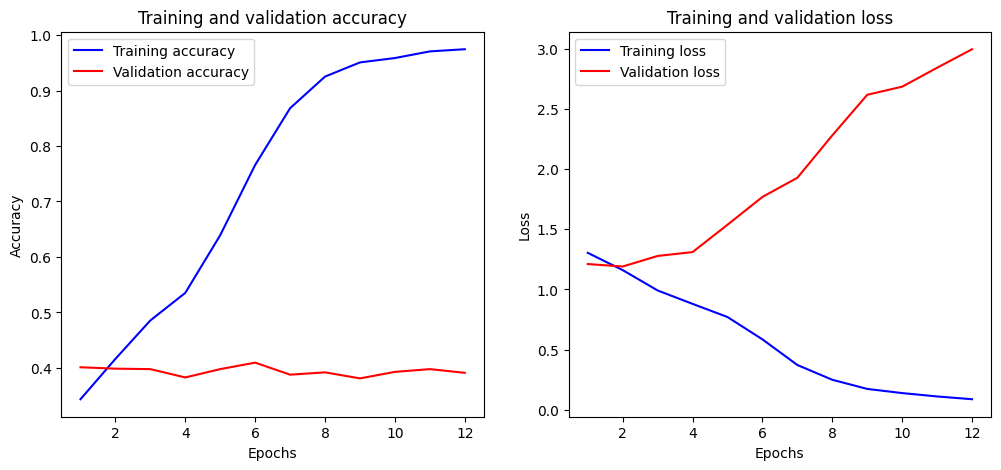

In [86]:
"""
Función para graficar los resultados del entramiento
"""
def plot_accuracy_and_loss(history):

    # Extraer datos de la historia de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Número de épocas
    epochs = range(1, len(acc) + 1)

    # Gráfica de accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfica de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_accuracy_and_loss(history)

Una vez terminado el entrenamiento se carga el mejor modelo guardado por el callback de ModelCheckpoint.

In [87]:
# Carga del mejor modelo
model = load_model('model.keras')

## **5. Resultados del modelo**

Quinto, se procede a calcular la matriz de confusión que arroja del modelo con respecto al conjunto de prueba. A partir de esta matriz, se derivan tres métricas importantes: precisión, recall y F1.

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Métricas derivadas de la matriz de confusión:
 - Precisión (Weighted): 0.3839
 - Recall (Weighted): 0.4225
 - F1 (Weighted): 0.3787


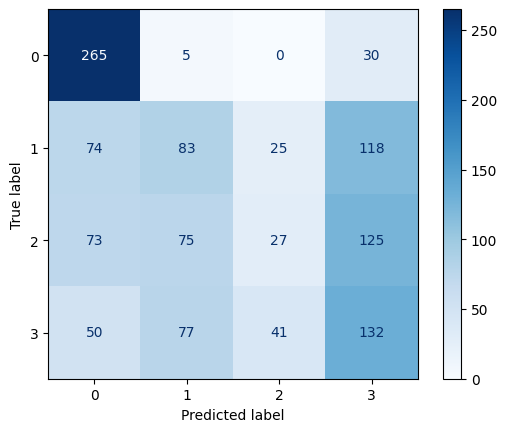

In [88]:
# Predecir etiquetas para el conjunto de prueba
y_pred = np.argmax(model.predict(X_test_seq), axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Calcular métricas adicionales basadas en la matriz de confusión
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar las métricas de la matriz de confusión
print("\nMétricas derivadas de la matriz de confusión:")
print(f" - Precisión (Weighted): {precision:.4f}")
print(f" - Recall (Weighted): {recall:.4f}")
print(f" - F1 (Weighted): {f1:.4f}")


El modelo muestra un desempeño limitado, con una precisión ponderada de 0.3839, un recall de 0.4225 y un F1-score de 0.3787. La clase 0 tiene el mejor rendimiento, pero las demás presentan confusión significativa, especialmente en las clases 1 y 3. Esto sugiere problemas para diferenciar patrones entre clases, posiblemente debido a desbalance de datos o características insuficientes.